In [1]:
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.DataFrame({'a': [1,2,3,4,5,6,7,8,7,6,5,4,3,2,1], 'b': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,100], 'c': [7]*15})
print(df)

    a    b  c
0   1    0  7
1   2    0  7
2   3    0  7
3   4    0  7
4   5    0  7
5   6    0  7
6   7    0  7
7   8    0  7
8   7    0  7
9   6    0  7
10  5    0  7
11  4    0  7
12  3    0  7
13  2    0  7
14  1  100  7


In [3]:
def find_potential_segments(signal: pd.DataFrame) -> pd.DataFrame:
    """
    this function identifies adjacent lines with the same class and collect them together as they're from the same call
    input: signal - df in which each line represents a single segment of seq_len and the probabilities of all classes
           num_samples, num_classes = signal.shape
    output: pd.DataFrame with potential sequences of the same class and their start and end indices
           num_potential_sequences <= num_samples
    """
    
    df = pd.DataFrame({'class': signal.idxmax(axis=1)})
    # aggregate sequential lines if they have the same prediction, and save their start and end original index
    current_class = None
    current_indices = []
    potential_segments = pd.DataFrame()
    for idx, row in df.iterrows():
        if current_class is None:
            current_class = row['class']
            current_indices.append(idx)
        elif current_class == row['class']:
            current_indices.append(idx)
        else:
            # add the merged result to the new DataFrame
            potential_segments = potential_segments.append(
                {'class': current_class, 'indices': [current_indices[0], current_indices[-1]]},
                ignore_index=True)

            # Reset for the next class
            current_class = row['class']
            current_indices = [idx]
    # take care of the last sequence and return
    return potential_segments.append(
                {'class': current_class, 'indices': [current_indices[0], current_indices[-1]]},
                ignore_index=True)

In [4]:
result_df = find_potential_segments(df)
print(result_df)

  class   indices
0     c    [0, 5]
1     a    [6, 8]
2     c   [9, 13]
3     b  [14, 14]


In [5]:
from librosa.core.spectrum import _spectrogram
def spectrogram_librosa(y, sr, nfft = None, hop_length = 256):
    # Compute spectrogram
    spectrogram, _ = _spectrogram(y=y,
                                 n_fft=nfft,
                                 hop_length=hop_length)

    # Convert to dB scale
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Display spectrogram
    librosa.display.specshow(spectrogram_db, x_axis='time')
    # plt.colorbar(format='%+2.0f dB')

shape: (110250,)
shape rms_diff: (1, 215)


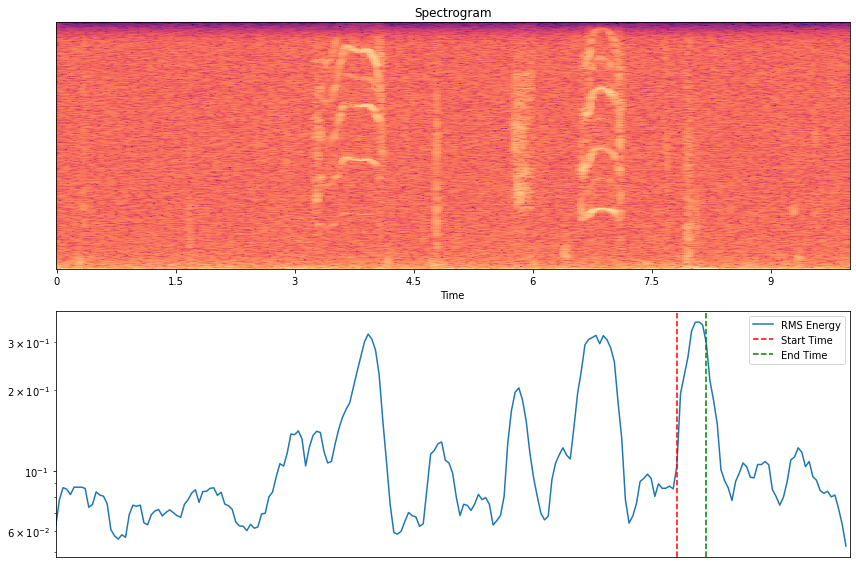

Call detected from 3.924 seconds to 4.110 seconds.


{'start': 3.924, 'end': 4.11}

In [6]:
### RMS

# load the audio file
# audio_file = "/home/shai/personal/soundbay/DeepVoice_Meetup/click_sample.wav"
audio_file = '/home/shai/personal/soundbay/DeepVoice_Meetup/manatee_sample.wav'
y, sr = librosa.load(audio_file)


def detection_rms_based(y, seq_len, nfft=2048, debug=False):
    # finds the most probable start and end time according to changes (gradient) in the RMS (Root Mean Square) energy of the audio signal
    print(f'shape: {y.shape}')
    rms = librosa.feature.rms(y=y)
    # gradient
    rms_diff = np.diff(rms)
    print(f'shape rms_diff: {rms_diff.shape}')

    
    # start time as the point with the largest positive gradient - relative to 0 sec
    start_frame = np.argmax(rms_diff)
    call_start = librosa.frames_to_time(start_frame)
    # sanity check - verify that the start time in inside the first seq_len as expected
    while call_start>seq_len:
        print(f'Attention: call_start is bigger than seq_len: {round(call_start,3)}>{seq_len}\nBreaking the sequence into 2:')
        start_frame = np.argmax(rms_diff[0,:start_frame])
        call_start = librosa.frames_to_time(start_frame)
        print(f'earlier potential call_start is: {call_start}')

    # end time as the point with the largest negative gradient after the start time
    end_frame = start_frame + np.argmin(rms_diff[0, start_frame:])  # search in the remaining frames
    call_end = librosa.frames_to_time(end_frame)
    
    if debug:
        # Plot the RMS energy and highlight the start and end times
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        spectrogram_librosa(y, sr, nfft=nfft)
        plt.title('Spectrogram')

        plt.subplot(2, 1, 2)
        plt.semilogy(rms.T, label='RMS Energy')
        plt.xticks([])
        plt.xlim([0, rms.shape[-1]])
        plt.legend(loc='best')

        # Highlight the start and end times
        plt.axvline(x=start_frame, color='r', linestyle='--', label='Start Time')
        plt.axvline(x=end_frame, color='g', linestyle='--', label='End Time')

        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()
        
        print(f"Call detected from {call_start:.3f} seconds to {call_end:.3f} seconds.")
    
    return {'start': round(call_start, 3), 'end': round(call_end, 3)}

detection_rms_based(y, 20, 2048, True)


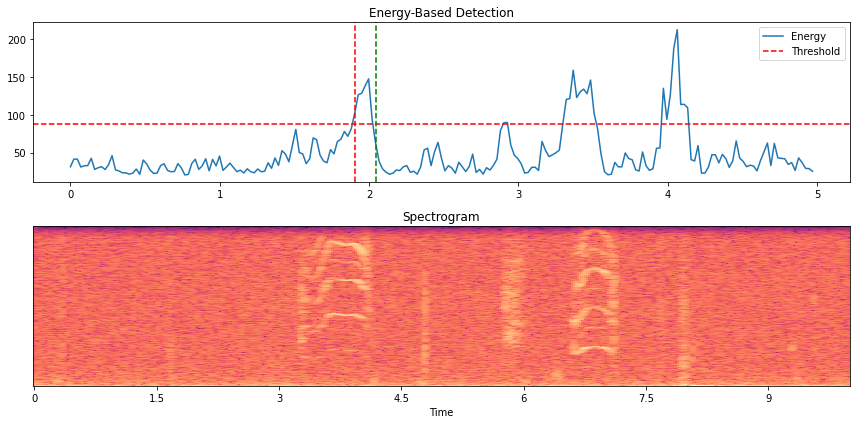

Call detected from 1.90 seconds to 2.04 seconds.


{'start': 1.904, 'end': 2.043}

In [7]:
# energy + magnitude based detection

def energy_based_det(y, frame_length, hop_length, energy_threshold=2, debug=False):
    # short-time energy in the time domain
    energy = np.sum(np.abs(librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)), axis=0)

    # set a threshold relative to the signal's median energy
    median_energy = np.median(energy)
    threshold = median_energy * energy_threshold

    # start time as the point where energy exceeds the threshold
    start_frame = np.argmax(energy > threshold)
    call_start = librosa.frames_to_time(start_frame, sr=sr, hop_length=hop_length)

    # end time as the point where energy drops below the threshold after the start time
    end_frame = start_frame + np.argmax(energy[start_frame:] < threshold)
    call_end = librosa.frames_to_time(end_frame, sr=sr, hop_length=hop_length)
    
    if debug:
        # Plot the energy for visualization
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        frame_times = librosa.frames_to_time(np.arange(len(energy)), sr=sr, hop_length=hop_length)
        plt.plot(frame_times, energy, label='Energy')
        plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
        plt.title('Energy-Based Detection')
        plt.legend(loc='best')
        # Highlight the start and end times
        plt.axvline(x=call_start, color='r', linestyle='--', label='Start Time')
        plt.axvline(x=call_end, color='g', linestyle='--', label='End Time')

        # Optionally, you can plot the spectrogram for further analysis
        plt.subplot(2, 1, 2)
        spectrogram_librosa(y, sr, nfft=2048)
        plt.title('Spectrogram')


        plt.tight_layout()
        plt.show()

        print(f"Call detected from {call_start:.2f} seconds to {call_end:.2f} seconds.")
    return {'start': round(call_start, 3), 'end': round(call_end, 3)}

energy_based_det(y, frame_length=512, hop_length=512, energy_threshold=2.4, debug=True)

## Image based algorithms

/home/shai/anaconda3/envs/dvoice/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
/home/shai/anaconda3/envs/dvoice/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.


shape: (216, 1025), min: 0.0, max: 4.39231742277876
shape: (216, 1025), min: 0.0, max: 4.39231742277876
shape: (216, 1025), min: 0.0, max: 1.0
shape: (216, 1025), min: 0.0, max: 1.0


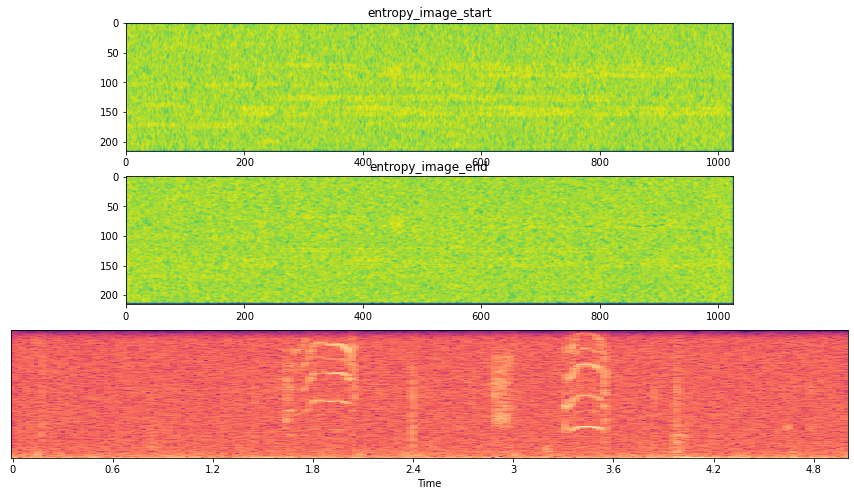

In [61]:
import skimage
from skimage.filters.rank import entropy
import cv2


# Compute spectrogram
spectrogram, _ = _spectrogram(y=y,
                             n_fft=2048)

# Convert to dB scale
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
norn_contrast_spectrogram = (spectrogram_db-spectrogram_db.min())/(spectrogram_db.max() - spectrogram_db.min())


# entropy
sobel_y_large = np.array([[-3, -2, -1, 0, 1, 2, 3],
                          [-3, -2, -1, 0, 1, 2, 3],
                          [-3, -2, -1, 0, 1, 2, 3],
                          [-3, -2, -1, 0, 1, 2, 3],
                          [-3, -2, -1, 0, 1, 2, 3],
                          [-3, -2, -1, 0, 1, 2, 3],
                          [-3, -2, -1, 0, 1, 2, 3]])

sobel_x_large = np.array([[-3, -3, -3, -3, -3, -3, -3],
                          [-2, -2, -2, -2, -2, -2, -2],
                          [-1, -1, -1, -1, -1, -1, -1],
                          [ 0,  0,  0,  0,  0,  0,  0],
                          [ 1,  1,  1,  1,  1,  1,  1],
                          [ 2,  2,  2,  2,  2,  2,  2],
                          [ 3,  3,  3,  3,  3,  3,  3]])
entropy_image_start = entropy(norn_contrast_spectrogram.T, sobel_y_large)
entropy_image_end = entropy(norn_contrast_spectrogram.T, sobel_x_large)


details = lambda x: print(f'shape: {x.shape}, min: {x.min()}, max: {x.max()}')
details(entropy_image_start)
details(entropy_image_end)

entropy_image_start_norm = entropy_image_start/entropy_image_start.max()
entropy_image_end_norm = entropy_image_end/entropy_image_end.max()

details(entropy_image_start_norm)
details(entropy_image_end_norm)

plt.figure(figsize=(15,8))
plt.subplot(3,1,1)
plt.imshow(entropy_image_start_norm, cmap='viridis')
plt.title('entropy_image_start')

plt.subplot(3,1,2)
plt.imshow(entropy_image_end_norm, cmap='viridis')
plt.title('entropy_image_end')
plt.subplot(3,1,3)
librosa.display.specshow(norn_contrast_spectrogram, x_axis='time')
plt.show()


In [90]:
# Canny
print(norn_contrast_spectrogram.dtype)
details(norn_contrast_spectrogram)
details(norn_contrast_spectrogram)
plt.imshow(cv2.Canny(norn_contrast_spectrogram+norn_contrast_spectrogram.min(), threshold1=120, threshold2=200, apertureSize=5))

int16
shape: (1025, 216), min: -32640, max: 32385
shape: (1025, 216), min: -32640, max: 31366


error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/canny.cpp:829: error: (-215:Assertion failed) _src.depth() == CV_8U in function 'Canny'
